<a href="https://colab.research.google.com/github/Megha2004/Data-Science/blob/main/ANPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and Import Dependencies

In [19]:
!pip install easyocr
!pip install imutils

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

Read in Image, Grayscale and Blur

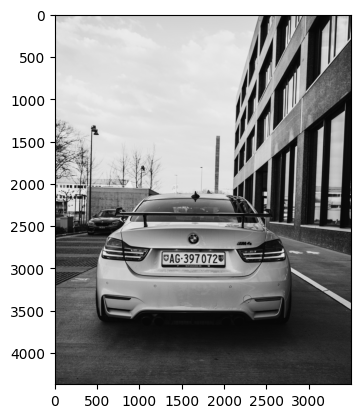

In [20]:
img = cv2.imread('/content/pexels-alexander-7372541.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

Apply filter and find edges for localization

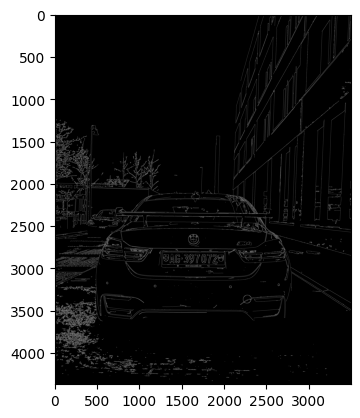

In [21]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

Find Contours and Apply Mask

In [22]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [23]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [24]:
location

array([[[1270, 2817]],

       [[1274, 2959]],

       [[2002, 2959]],

       [[1995, 2817]]], dtype=int32)

In [25]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

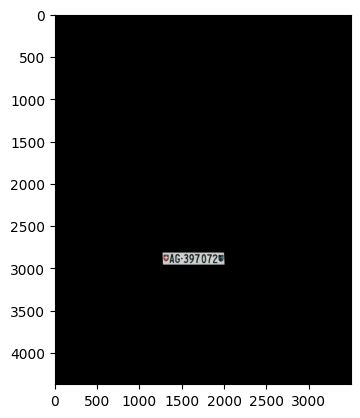

In [26]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [27]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

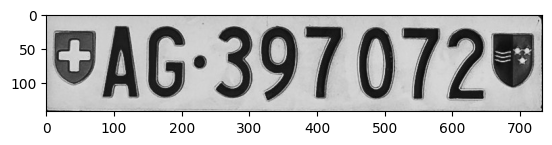

In [28]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

Use Easy OCR To Read Text

In [29]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[79, 5], [724, 5], [724, 140], [79, 140]], 'Ag3970725', 0.6347821620174754)]

Render Result

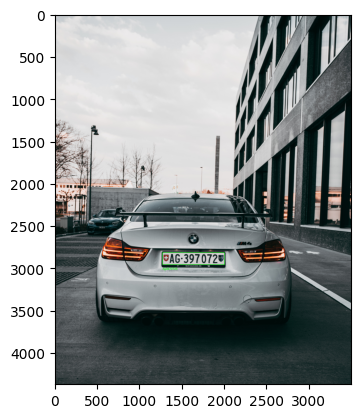

In [30]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [34]:
import urllib.request

# Download YOLOv3 configuration file
url = "https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true"
urllib.request.urlretrieve(url, '/content/yolov3.cfg')

('/content/yolov3.cfg', <http.client.HTTPMessage at 0x7b2caa282fb0>)

In [50]:
import cv2
import numpy as np
import easyocr

# Load YOLO for car detection
yolo_net = cv2.dnn.readNet('/content/yolov3.weights', '/content/yolov3.cfg')
with open('/content/coco.names', 'r') as f:
    yolo_classes = f.read().strip().split('\n')

# Load the image
img = cv2.imread('/content/TN.jpg')

# Perform car detection using YOLO
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
yolo_net.setInput(blob)
yolo_outs = yolo_net.forward(yolo_net.getUnconnectedOutLayersNames())

# Process the YOLO output
conf_threshold = 0.5
boxes = []

for out in yolo_outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold and yolo_classes[class_id] == 'car':
            center_x, center_y, w, h = (detection[0:4] * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])).astype(int)
            x, y = int(center_x - w / 2), int(center_y - h / 2)
            boxes.append([x, y, int(w), int(h)])

# License plate recognition on the entire image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Continue with license plate recognition using EasyOCR
reader = easyocr.Reader(['en'])
result = reader.readtext(gray)
print("EasyOCR Results:")

for detection in result:
    print(detection)

# Extract license plates based on proximity to detected cars
for detection in result:
    text, coords = detection[-2], detection[0]
    x, y = int(coords[0][0]), int(coords[0][1])

    for box in boxes:
        x_car, y_car, w_car, h_car = box
        if x_car < x < x_car + w_car and y_car < y < y_car + h_car:
            # Extract only alphanumeric characters from the license plate text
            license_plate = ''.join(char for char in text if char.isalnum())
            print("License Plate:", license_plate)

EasyOCR Results:
([[129, 217], [155, 217], [155, 233], [129, 233]], 'IND', 0.9988696265385796)
([[170, 180], [467, 180], [467, 235], [170, 235]], 'TN 01 AS 9299', 0.9225412850150833)
